In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os as os
import csv, sqlite3
import seaborn as sns

In [2]:
input_file_name = input("Please input file name：ECQ_D.csv: ")  ## Enter key to confirm input

Please input file name：ECQ_D.csv: ECQ_D.csv


In [3]:
#Set Data path and variables to read
os.chdir(r"C:\\Users\laura\Desktop\dissertation\Python\AI_model\ECQ_10_years_PA7")# You may change the path accordingly
subset_varible=["SEQN","ECD010","ECQ020","ECQ060","ECD070A","MCQ080E","WHQ030E"]  # Filter specified variables

In [4]:
data=pd.read_csv(input_file_name)
data1 = data[subset_varible]

In [5]:
data1 = data1.dropna(axis = 0, how ='any') #Remove Empty data
data1 = data1[data1.ECD010 <= 60] ; data = data[data.ECQ060 <= 2]
data1 = data1[data1.ECD070A <= 20] ; data = data[data.WHQ030E <= 3]
data1 = data1[data1.MCQ080E <= 2] ; data = data[data.ECQ020 <= 2]#Remove abnormal data
data1.MCQ080E[data1['MCQ080E'] == 2] = 0 #Change value 2 to 0 which means overweight
print(data1.shape) #Check data dimension
data1=data1[~data1['ECD010'].isin([999])] # Remove column contains infinity value: 999
data1.head()

(3171, 7)


,SEQN,ECD010,ECQ020,ECQ060,ECD070A,MCQ080E,WHQ030E
1,31128.0,33.0,1.0,1.0,4.0,0.0,2.0
2,31129.0,19.0,2.0,2.0,6.0,0.0,3.0
4,31137.0,17.0,2.0,2.0,7.0,0.0,1.0
5,31138.0,21.0,2.0,2.0,7.0,0.0,3.0
6,31140.0,31.0,2.0,2.0,10.0,0.0,3.0


In [6]:
import sqlite3
# import cx_Oracle 'username/password@hostname:port/service_name'
# connect function opens a connection to the SQLite database file, 
conn = sqlite3.connect('database.db')
#Similarly we will make connection with other databases like Oracle, DB2 etc.
print(conn)

In [7]:
# Drop a table name Crypto if it exists already
try:
    conn.execute('DROP TABLE IF EXISTS `tan2345` ')
except Exception as e:
    raise(e)
finally:
    print('Table dropped')

Table dropped


In [8]:
# python check whether table in sqlite exist or not，if not, then create one
def create_table():
    conn = sqlite3.connect("database.db")
    try:
        create_tb_cmd='''
       create table tan2345(SEQN integer ,ECD010 integer,ECQ020 integer,ECQ060 integer,WHQ030E integer,ECD070A integer,MCQ080E integer);
        '''
        conn.execute(create_tb_cmd)
    except:
        print("Create table failed")
        return False
    #conn.execute(insert_dt_cmd)
    conn.commit()
create_table()

In [9]:
conn = sqlite3.connect("database.db")
cu=conn.cursor()
data1.to_sql('tan2345',conn, if_exists='append', index=False)  # Inject the newly read data into the database table data in the form of a data frame
conn.commit()

In [10]:
##Read data from database
conn = sqlite3.connect("database.db")
#print(conn)
sql="SELECT * from tan2345"
newdata=pd.read_sql(sql,conn)
newdata.head()

,SEQN,ECD010,ECQ020,ECQ060,WHQ030E,ECD070A,MCQ080E
0,31128,33,1,1,2,4,0
1,31129,19,2,2,3,6,0
2,31137,17,2,2,1,7,0
3,31138,21,2,2,3,7,0
4,31140,31,2,2,3,10,0


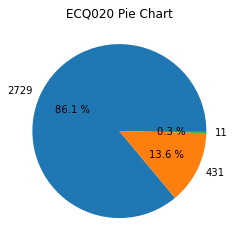

In [11]:
num_list = list(newdata['ECQ020'].value_counts()) #获取列ECQ020数据
#name_list = list(newdata['ECQ020'].value_counts().index) #获取列ECQ020有哪些值
plt.axes(aspect = 1) #饼图类型
plt.pie(x = num_list, labels = num_list, autopct = '%3.1f %%') #饼图
plt.title('ECQ020' + ' Pie Chart') #设置标题
plt.show()

对变量“ECQ020”（母亲怀孕时抽烟）绘制饼图，从上图可以看出有14%的母亲选项为1即孕期吸烟，86%的母亲选项为2即孕期不吸烟。

In [12]:
# #labels=['ECD010','ECQ020','ECQ060','WHQ030E','ECD070A','MCQ080E']
# plt.pie(newdata['ECD010'],newdata['ECQ020'],newdata['ECQ060'],newdata['WHQ030E'],newdata['ECD070A'],newdata['MCQ080E'])
# #plt.show() 

In [13]:
#newdata.groupby(['ECD070A']).plot(kind='pie',y='MCQ080E' )

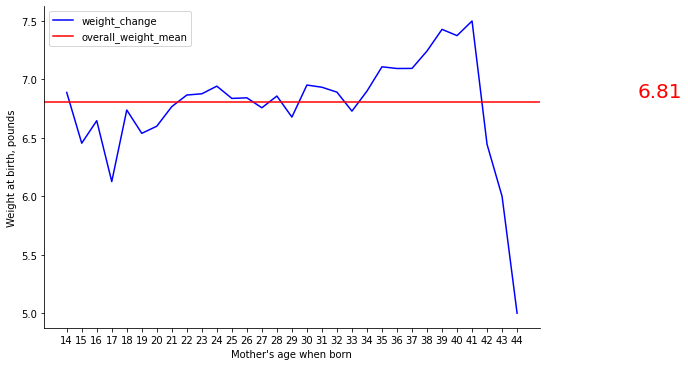

In [14]:
overall_weight_mean = newdata.mean()["ECD070A"]  # Calculate overall average weight
weight_change = newdata.groupby("ECD010").mean()["ECD070A"]  # The average baby weight changes with the age of the mother when giving birth
x_data = [str(int(i)) for i in weight_change.index] ; y_data = weight_change.values
sns.relplot(x=x_data,y=y_data, kind="line",color = 'b', label = 'weight_change',aspect=1.5) #Line Chart
plt.axhline(y = overall_weight_mean, color = 'r', label = 'overall_weight_mean') #Add the average line 
plt.text(38, 6.85, round(overall_weight_mean, 2), fontdict = {'size' : '20','color' : 'r'}) #Add value label
plt.legend() #Legend
plt.ylabel("Weight at birth, pounds") ; plt.xlabel("Mother's age when born") #Set x-axis and y-axis labels
plt.show()
#sns.set(rc={"figure.figsize":(3, 4)}) #width=3, #height=4

In [15]:
Kdata = newdata[subset_varible[1:]] #Remove first column
Kdata = (Kdata - Kdata.mean(axis  =0))/(Kdata.std(axis = 0)) #z-score Strandardize
Kdata.head()

,ECD010,ECQ020,ECQ060,ECD070A,MCQ080E,WHQ030E
0,1.173061,-1.639708,-1.995253,-1.980839,-0.329707,-0.845599
1,-1.138487,0.206055,0.273283,-0.570117,-0.329707,0.479855
2,-1.468708,0.206055,0.273283,0.135244,-0.329707,-2.171052
3,-0.808266,0.206055,0.273283,0.135244,-0.329707,0.479855
4,0.842840,0.206055,0.273283,2.251327,-0.329707,0.479855


# Clustering Analysis

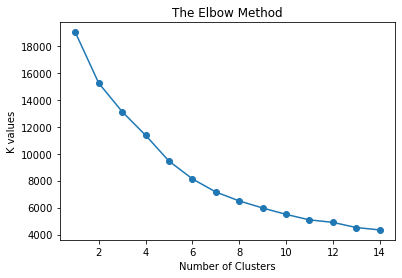

In [16]:
# Using the elbow method to find the optimal number of clusters
SSE = []  # Store the sum of squared errors of each result
for k in range(1, 15):
    estimator = KMeans(n_clusters = k)  # Construct a clusterer
    estimator.fit(Kdata)
    SSE.append(estimator.inertia_)
X = range(1, 15)
plt.plot(X, SSE, 'o-')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('K values')
plt.show()

We can see the point 5 is the turning point which is decreasing sharply.That means clustering the dataset into 5 categories should be the best choice

In [17]:
kmodel = KMeans(n_clusters = 5) #Cluster Group set to 5
kmodel.fit(Kdata) #Train Model 
label = pd.Series(kmodel.labels_)  # Fetch types of each sample
num = pd.Series(kmodel.labels_).value_counts()  # Count the number of categories corresponding to each sample 统计各样本对应的类别的数目
center = pd.DataFrame(kmodel.cluster_centers_)  # Find cluster centers, horizontal variables, vertical categories找出聚类中心,横变量，纵类别
#Max = center.values.max() ; Min = center.values.min()
X = pd.concat([center, num], axis = 1)  # Horizontal connection (0 is vertical) to get the number of categories corresponding to the cluster center横向连接（0是纵向），得到聚类中心对应的类别数目  
X.columns = list(Kdata.columns) + ['Number'] # Add a "number" column
X

,ECD010,ECQ020,ECQ060,ECD070A,MCQ080E,WHQ030E,Number
0,0.000776,-0.094541,-1.982290,-1.057823,-0.310497,0.086006,350
1,-0.714672,-0.084069,0.279737,-0.049374,-0.329707,0.109369,1406
2,-0.135494,-0.045640,-0.028697,0.158146,3.032036,-1.318975,308
3,-0.523075,13.126397,2.541819,-0.570117,-0.024094,-0.243120,11
4,0.959893,0.019121,0.256724,0.362427,-0.329707,0.205332,1096


In [32]:
Kdata['Type'] = label.values
Kdata.head()

TypeError: list indices must be integers or slices, not str

In [33]:
X.columns = ["ID","Mother's age when born", "Mother smoked when pregnant",
                   "Receive newborn care at health facility", "Weight at birth, pounds",
                     "Doctor confirmed overweight", "How do you consider weight"]
#X['Type'] = label.values
X.head()

,ID,Mother's age when born,Mother smoked when pregnant,Receive newborn care at health facility,"Weight at birth, pounds",Doctor confirmed overweight,How do you consider weight
0,0.000776,-0.094541,-1.982290,-1.057823,-0.310497,0.086006,350
1,-0.714672,-0.084069,0.279737,-0.049374,-0.329707,0.109369,1406
2,-0.135494,-0.045640,-0.028697,0.158146,3.032036,-1.318975,308
3,-0.523075,13.126397,2.541819,-0.570117,-0.024094,-0.243120,11
4,0.959893,0.019121,0.256724,0.362427,-0.329707,0.205332,1096


In [21]:
As we know, the dataset can be clustered into five groups/categories  

SyntaxError: invalid syntax (<ipython-input-21-f1d2e5b3df21>, line 1)

# Scatter Analysis

fig = plt.figure(figsize=(10, 4)) # Set Figure size
sns.scatterplot(data=Kdata, x=Kdata.ECD010[Kdata['Category'] == 0],y= Kdata.ECD070A[Kdata['Category'] == 0], label = "Category 0")
sns.scatterplot(data=Kdata, x=Kdata.ECD010[Kdata['Category'] == 1],y= Kdata.ECD070A[Kdata['Category'] == 1], label = "Category 1")
sns.scatterplot(data=Kdata, x=Kdata.ECD010[Kdata['Category'] == 2],y= Kdata.ECD070A[Kdata['Category'] == 2], label = "Category 2")
sns.scatterplot(data=Kdata, x=Kdata.ECD010[Kdata['Category'] == 3],y= Kdata.ECD070A[Kdata['Category'] == 3], label = "Category 3")
sns.scatterplot(data=Kdata, x=Kdata.ECD010[Kdata['Category'] == 4],y= Kdata.ECD070A[Kdata['Category'] == 4], label = "Category 4")
plt.ylabel("Weight at birth, pounds") ; plt.xlabel("Mother's age when born")
plt.legend()
plt.show()

In [ ]:
Kdata.loc[Kdata['Category']==3]
Kdata.loc[(Kdata['ECD010']) & (Kdata['column_name'] <= B)]

Conclusion: From the Scatter we can see the Category 3 is the majority, after checking the table, we found the younger the mother's age, the higher baby's weight

In [ ]:
#del Kdata['Type'] #删除列
#np.ravel(Kdata)
#plt.xlabel('k') ; plt.ylabel('SSE')
#需要进行的聚类类别数
# k = 5 
# #读取数据并进行聚类分析
# #读取数据
# #data = pd.read_csv(input_file_name) 

# #调用k-means算法，进行聚类分析
# kmodel = KMeans(n_clusters = k) 
# #训练模型
# kmodel.fit(Kdata) 

# #查看聚类中心
# print(kmodel.cluster_centers_) 
# #查看各样本对应的类别
# print(kmodel.labels_ )

In [96]:
# label = pd.Series(kmodel.labels_)  # 各样本的类别
# num = pd.Series(kmodel.labels_).value_counts()  # 统计各样本对应的类别的数目
# center = pd.DataFrame(kmodel.cluster_centers_)  # 找出聚类中心,横变量，纵类别
# Max = center.values.max() ; Min = center.values.min()
# X = pd.concat([center, num], axis = 1)  # 横向连接（0是纵向），得到聚类中心对应的类别数目  <class 'pandas.core.frame.DataFrame'>
# X.columns = list(Kdata.columns) + ['NUM']  # 表头加上一列
# X

In [20]:
#mean_result = mean_result[mean_result.index <= 35]  # 筛选出年龄小于等于35岁
# # Using the elbow method to find the optimal number of clusters
# SSE = []  # 存放每次结果的误差平方和
# for k in range(1, 15):
#     estimator = KMeans(n_clusters = k)  # 构造聚类器
#     estimator.fit(Kdata)
#     SSE.append(estimator.inertia_)
# X = range(1, 15)
# plt.plot(X, SSE, 'o-')
# #plt.xlabel('k') ; plt.ylabel('SSE')
# plt.title('The Elbow Method')
# plt.xlabel('Number of Clusters')
# plt.ylabel('array')
# plt.show()

In [93]:
#手肘发
# # Using the elbow method to find the optimal number of clusters
# from sklearn.cluster import KMeans
# a = []
# for i in range(2,15):
#     kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, init = 'k-means++', random_state = 0)
#     kmeans.fit(X)
#     a.append(kmeans.inertia_)
# plt.plot(range(2,15), a)
# plt.title('The Elbow Method')
# plt.xlabel('Number of Clusters')
# plt.ylabel('array')
# plt.show()

# Radar Chart  

In [68]:
#Radar Chhart
# fig = plt.figure(figsize = (8,6))
# ax = fig.add_subplot(111, polar=True) #polar=True 画圆形
# feature = list(Kdata.columns)
# center_num = X.values  #<class 'numpy.ndarray'>
# N = len(feature) ; total = X.NUM.sum()

# for i, v in enumerate(center_num):
#     # 设置雷达图的角度，用于平分切开一个圆面
#     angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
#     # 为了使雷达图一圈封闭起来，需要下面的步骤
#     center = np.concatenate((v[:-1], [v[0]]))
#     angles = np.concatenate((angles, [angles[0]]))
#     np.ravel(center); np.ravel(angles);np.ravel(center_num);np.ravel(Kdata); np.ravel(X);np.ravel(total);
#     # 绘制折线图
#     ax.plot(angles, center, 'o-', linewidth=2, label="NO.%d = %d (%.2f%%)" % (i, v[-1],v[-1]*100/total))
#     # 填充颜色
#     ax.fill(angles, center, alpha=0.25)
#     # 添加每个特征的标签
#     ax.set_thetagrids(angles * 180 / np.pi, feature, fontsize=12)
#     # 设置雷达图的范围
#     ax.set_ylim(Min - 0.1, Max + 0.1)
#     # 添加标题
#     plt.title('SHOP_CLUSTERING', fontsize=20)
#     # 添加网格线
#     ax.grid(True)
#     # 设置图例
#     plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), ncol=1, fancybox=True, shadow=True)
#plt.show() # 显示图形

In [2]:
# y_mean = Kdata['ECD070A'].mean() #计算列ECD070A平均值
# l = Kdata.shape[0] #获取行数
# np.random.seed(321) #设置随机数种子，确保每次产生随机数相同
# x = Kdata['ECD010'].values + np.random.randint(-500, 500, l) /50
# np.random.seed(123) #设置随机数种子，确保每次产生随机数相同
# y = Kdata['ECD070A'].values + np.random.randint(-500, 500, l)/50
# plt.scatter(x, y, alpha = 0.35) #散点图(alpha设置散点透明度)
# plt.axhline(y = y_mean, color = 'r') #添加均值线
# plt.title('ECD010' + '-' + 'ECD070A' + ' Scatter plot') #设置标题
# plt.ylabel('ECD070A') ; plt.xlabel('ECD010') #设置x轴，y轴标签
# plt.show()

In [3]:
# label = list(data['ECQ060'].value_counts().index) #获取列MCQ080E有哪些值
# v = [] #创建空列表
# for i in label: #按列MCQ080E对ECD070A进行分组
#     vi = list(data[data['ECQ060'] == i]['ECD070A'].values)
#     v.append(vi)
# plt.boxplot(v, labels = label) #箱线图
# plt.ylabel('ECD070A') ; plt.xlabel('ECQ060') #设置x轴,y轴标签
# plt.show()

In [4]:
#Kdata.boxplot(column=["ECD010","ECQ020","ECD070A","MCQ080E"])

SyntaxError: invalid character in identifier (<ipython-input-4-580f4f69b8d4>, line 1)

In [5]:
#Kdata.boxplot(column=["ECD010","ECQ020","ECQ060","ECD070A","MCQ080E","WHQ030E"])

In [6]:
#Kdata.hist(column=['ECD010','ECQ020','ECD070A','MCQ080E'])

# Pie Chart

In [7]:
#Kdata.groupby(['ECD070A']).plot(kind='pie',y='MCQ080E' )

# Bar Chart

In [8]:
#plt.bar(Kdata['ECD010'],Kdata['ECQ020'],Kdata['ECD070A'],Kdata['MCQ080E'])